# EDS296: Final Mini-Project
### **Authors**

Carmen Hoyt choyt@ucsb.edu

Ryan Green **EMAIL**

Rachel Swick **EMAIL**

### [GitHub Repository](https://github.com/ceh58/eds296-final)

## Introductcion

1. Choose a spatial region you find interesting, for whatever reason.

Write a few paragraphs about this place! Include a relevant graphic or two (can be an
infographic or map from the Internet) showing the geographical and climatological context
of your region. What’s going on there? What types of extreme events are relevant? How
might you expect that climate change impacts could be felt by human or natural systems?

**Region**: Indonesia

**Bounding box**: [92, 146, -15, 10]

**Climate**: 

Indonesia has a tropical climate, experiencing two seasons: wet (November-April) and dry (May-October).  It is a key part of the Coral Triangle, a region with at least 500 species of important reef-building corals. Corals are highly sensitive to changes in water temperature, and will bleach (expel their zooxanthellae) after prolonged exposure to warmer temperatrues (or changes of greater than 1°C). I would expect climate change to drive ocean temperatures up, leading to widespread bleaching and mass coral loss. Coral loss has many implications for the oceans and the people that depend on them, such as loss in food source, coastal protection, and tourism. 

Indonesia's first mass bleacing event was recorded in [1997-1998](https://indonesia.wcs.org/Initiatives/Marine/Coral-Bleaching.aspx). Since then, there have also been bleaching events in [2016-2017 and 2021](https://theseapeople.org/2024/12/18/coral-bleaching-raja-ampat/). 

<img src="coral_triangle.png" alt="Coral Triangle" width="75%">

Thus, I am interested in looking at historical (1900-1930) and late century (1995-2025) average sea surface temperatures. I chose the late 20th century time period to cover the span of the mass bleaching events to see if there was a significant change (increase) in ocean temperature as compared to the historical temperature. 

**Write about how affected by el nino/la nina!!**

## Metrics Definition

2. Define metrics you plan to use to assess climate change impacts in your region.

Given the context you just provided in item 1, decide on two different ‘metrics’, or quantities
to be calculated from climate model output, that will help you quantify climate change
impacts. Some examples of useful metrics might be:

- Regional averages (to let you plot time series)
- Time averages (to let you plot maps)
- Correlation patterns

You’ll also need to decide on a set of variables to include, from which to calculate the
metrics above. This could be temperature, precipitation, wind, or anything else you can find
that you think is helpful

**Metrics**:

1. Regional averages

This will allow us to quantify climate change impacts over time regarding changes in 'pr' and 'tos'. Are they seeing similar trends? 

2. Correlation patterns

Regression: How quickly are changes in 'pr' and 'tos' happening (rate of change)?

**Variables**:

- "pr"

Since Indonesia has wet and dry seasons, precipitation can be an important indicator for climate change impacts.

- "tos"

Additionally, much of Indonesia's economy is reliant upon the ocean. Changes in sea surface temperature could have detrimental effects.


## Data I/O

3. Extract necessary climate (historical plus projection) data for that region.

Write code to extract the variables you need to do your calculations, and to store these in
local memory in a way that makes it easy to compute the metrics you’ve chosen. For
instance: generating an xarray object containing all ensemble members for your chosen set of
climate models!
Note: I recommend choosing a subset of climate models and scenarios to use for this
analysis, since you likely won’t be able to look at everything. Picking something like 2-3
different climate models and 1-2 different scenarios to work with should let you have a good
range of estimates, without putting TOO much demand on your laptop’s memory!


**Climate models**:

- CESM2

**ADD DESCRIPTION**

- ACCESS-CM2

The [ACCESS-CM2 (Australian Community Climate and Earth-System Simulator Coupled Model version 2)](https://research.csiro.au/access/about/cm2/) is a climate model developed by the Australian Bureau of Meteorology and CSIRO for participation in the CMIP6 (Coupled Model Intercomparison Project Phase 6). Ocean variables are modeled using MOM5 (Modular Ocean Model version 5) at 1 x 1 degree resolution.

**Scenarios**:

- SSP370: 'Regional Rivalry' 

The SSP3-7.0 scenario (Shared Socioeconomic Pathway 3 with a radiative forcing of 7.0 W/m² by 2100) is one of the future climate projections used in CMIP6. It represents a high-emissions pathway, with CO² emissions projected to double by 2100. This can lead to significant challenges in both mitigation and adaptation.

- SSP585: 'Fossil-Fueled Development'

The SSP5-8.5 scenario (Shared Socioeconomic Pathway 5 with a radiative forcing of 8.5 W/m² by 2100) is the highest-emissions pathway in the CMIP6 framework and represents a fossil-fueled development future. It predicts very high GHG emissions, with CO2 emissions tripling by 2075. This scenario provides insight into the upper range of climate system response to greenhouse gas forcing, useful for stress-testing infrastructure, understanding tipping points, and preparing for high-impact outcomes.


### Import Packages

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


### Access the CMIP6 Database

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

#### CESM2 Model

##### Search Catalog

In [3]:
# Specify search terms to query catalog 
# activity_id: which downscaling technique do you want?
activity_id = ["CMIP"]

# experiment_id: which historical/future scenario do you want?
experiment_id = ["historical", "ssp370"]

# table_id: which part of the Earth system/time resolution do you want?
table_id = ["Amon", "Omon"] # both atmos and ocaen

# source_id: which model do you want?
source_id = ["CESM2"]

# variable_id: which variable do you want?
variable_id = ["tos", "pr"]

##### Store 'tos'

In [4]:
# Search through catalog, store results for tos
cesm_res_tos = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, 
                         variable_id='tos', grid_label='gr') # remove gn

# Recreate the data frame
cesm_tos_df = cesm_res_tos.df

# Display the data frame
cesm_tos_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r3i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r5i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r2i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
4,CMIP,NCAR,CESM2,historical,r6i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
5,CMIP,NCAR,CESM2,historical,r4i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190308
6,CMIP,NCAR,CESM2,historical,r7i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
7,CMIP,NCAR,CESM2,historical,r8i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
8,CMIP,NCAR,CESM2,historical,r9i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190311
9,CMIP,NCAR,CESM2,historical,r10i1p1f1,Omon,tos,gr,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313


##### Store 'pr'

In [5]:
# Search through catalog, store results for precip
cesm_res_pr = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, 
                         variable_id='pr')

# Recreate the data frame
cesm_pr_df = cesm_res_pr.df

# Display the data frame
cesm_pr_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
2,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
3,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
4,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
5,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
6,CMIP,NCAR,CESM2,historical,r7i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
7,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190401
8,CMIP,NCAR,CESM2,historical,r11i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190514
9,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20200124


In [6]:
# Define list of ensemble members
# tos
mems_tos = cesm_tos_df.member_id.unique()

# pr
mems_pr = cesm_pr_df.member_id.unique()

# Find the ones each list has in common
common_mems = list(set(mems_tos) & set(mems_pr))

# Print
print(common_mems)

['r4i1p1f1', 'r1i1p1f1', 'r6i1p1f1', 'r7i1p1f1', 'r11i1p1f1', 'r5i1p1f1', 'r2i1p1f1', 'r8i1p1f1', 'r3i1p1f1', 'r9i1p1f1', 'r10i1p1f1']


In [7]:
# Define empty lists for output data
cesm_tempdata = []
cesm_prdata = []

# Loop over all common ensemble members; grab both temperature
# and precip for each member
for mem in range(len(common_mems)):
    print(common_mems[mem])

    # Extract member of interest
    prec_cesm_df = cesm_pr_df[(cesm_pr_df["member_id"] == common_mems[mem])]
    tos_cesm_df = cesm_tos_df[(cesm_tos_df["member_id"] == common_mems[mem])]
    
    # Store data as xarray
    hist_pr = xr.open_zarr(prec_cesm_df['zstore'].iloc[0], storage_options={'anon': True}).load()
    hist_tos = xr.open_zarr(tos_cesm_df['zstore'].iloc[0], storage_options={'anon': True}).load()
    
    # Reassign time for all entries aside from the first one
    if mem == 0:
        common_time = hist_tos.time
    else:
        hist_tos['time'] = common_time    
        
    # Add to list
    cesm_tempdata.append(hist_tos)
    cesm_prdata.append(hist_pr)

r4i1p1f1
r1i1p1f1
r6i1p1f1
r7i1p1f1
r11i1p1f1
r5i1p1f1
r2i1p1f1
r8i1p1f1
r3i1p1f1
r9i1p1f1
r10i1p1f1


In [8]:
# Concatenate the list into a single xarray object
cesm_tempdata = xr.concat(cesm_tempdata, dim="member")
cesm_prdata = xr.concat(cesm_prdata, dim="member")

# Store the actual member information as values of the new dimension
cesm_tempdata = cesm_tempdata.assign_coords(member=("member", common_mems))
cesm_prdata = cesm_prdata.assign_coords(member=("member", common_mems))

# Reformat time dimension for concatenated array
cesm_tempdata['time'] = cesm_tempdata.time.astype('datetime64[ns]')

In [9]:
# Specify rough lat/lon bounds for NINO3.4
lat_min, lat_max = -15, 10
lon_min, lon_max = 92, 146

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
mask_lat = (cesm_tempdata.lat >= lat_min) & (cesm_tempdata.lat <= lat_max)
mask_lon = (cesm_tempdata.lon >= lon_min) & (cesm_tempdata.lon <= lon_max)

# Find points where the mask value is True, drop all other points
cesm_indo = cesm_tempdata.where(mask_lat & mask_lon, drop=True)

# Average over the lat and lon dimensions
cesm_indo = cesm_indo.mean(dim="lat").mean(dim="lon")

In [10]:
# Calculate seasonal average
cesm_indo_clim = cesm_indo.groupby("time.month").mean("time")

# Print output to see what it looks like
print(cesm_indo_clim)

<xarray.Dataset>
Dimensions:  (month: 12, member: 11)
Coordinates:
  * member   (member) <U9 'r4i1p1f1' 'r1i1p1f1' ... 'r9i1p1f1' 'r10i1p1f1'
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tos      (month, member) float32 29.4 29.4 29.41 29.4 ... 29.51 29.5 29.52


In [11]:
# Remove seasonal mean to get the anomaly
cesm_indo_anom = cesm_indo.groupby("time.month") - cesm_indo_clim

Text(0, 0.5, 'Indonesia SST anomaly (C)')

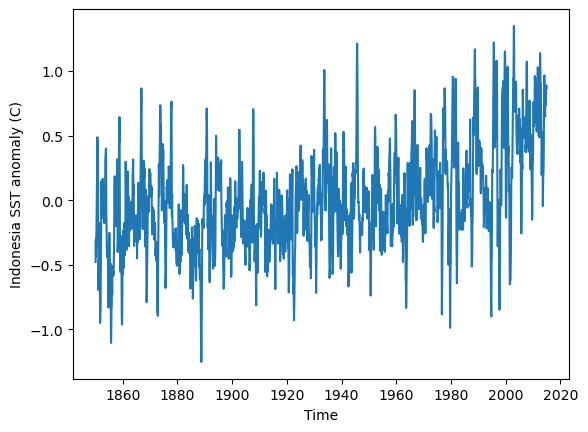

In [13]:
plt.plot(cesm_indo_anom.time, cesm_indo_anom.tos.isel(member=0))
plt.xlabel('Time')
plt.ylabel('Indonesia SST anomaly (C)')

In [14]:
# Type of coefficient
# 0 = correlation, 1 = regression
coef_type = 1

In [15]:
# Define correlation and regression functions

# 1) correlation
# Input data: two time series called x and y
def corr_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)
    
    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    
    # Output data: R, p-value for x vs y
    r, p = stats.pearsonr(x[mask], y[mask])
    
    return float(r), float(p)

# 2) regression
# Input data: two time series called x and y
def reg_ts(x, y):
    # Get rid of any Nan/Inf values
    mask = np.isfinite(x) & np.isfinite(y)

    # Make sure there is still data
    if mask.sum() < 2:
        return np.nan, np.nan
    
    # Perform regression on good data, return slope and p-value
    regval = stats.linregress(x[mask], y[mask])
    return regval.slope, regval.pvalue

In [16]:
# Force tos, pr time dimensions to match
cesm_prdata['time'] = cesm_indo_anom.time

In [17]:
# Select data from a single ensemble member to make things run faster
this_indo = cesm_indo_anom.isel(member=0).tos
this_pr = cesm_prdata.isel(member=0).pr

# broadcast NINO3.4 across lat/lon dimension
this_indo_broadcasted = xr.DataArray(
    np.broadcast_to(this_indo.values[:, np.newaxis, np.newaxis], this_pr.shape),
    dims=["time", "lat", "lon"],
    coords={"time": this_indo.time, "lat": this_pr.lat, "lon": this_pr.lon}
)

In [18]:
# Use apply_ufunc to do the looping over lat/lon, for a single member
if coef_type == 0:
    coef_vals, p_vals = xr.apply_ufunc(corr_ts, this_indo_broadcasted, this_pr,  
        input_core_dims=[['time'], ['time']], output_core_dims=[[], []],
        vectorize=True, dask='parallelized', dask_gufunc_kwargs={'allow_rechunk': True}, output_dtypes=[float, float]
    )    
elif coef_type == 1:
    coef_vals, p_vals = xr.apply_ufunc(reg_ts, this_indo_broadcasted, this_pr,  
        input_core_dims=[['time'], ['time']], output_core_dims=[[], []],
        vectorize=True, dask='parallelized', dask_gufunc_kwargs={'allow_rechunk': True}, output_dtypes=[float, float]
    )   

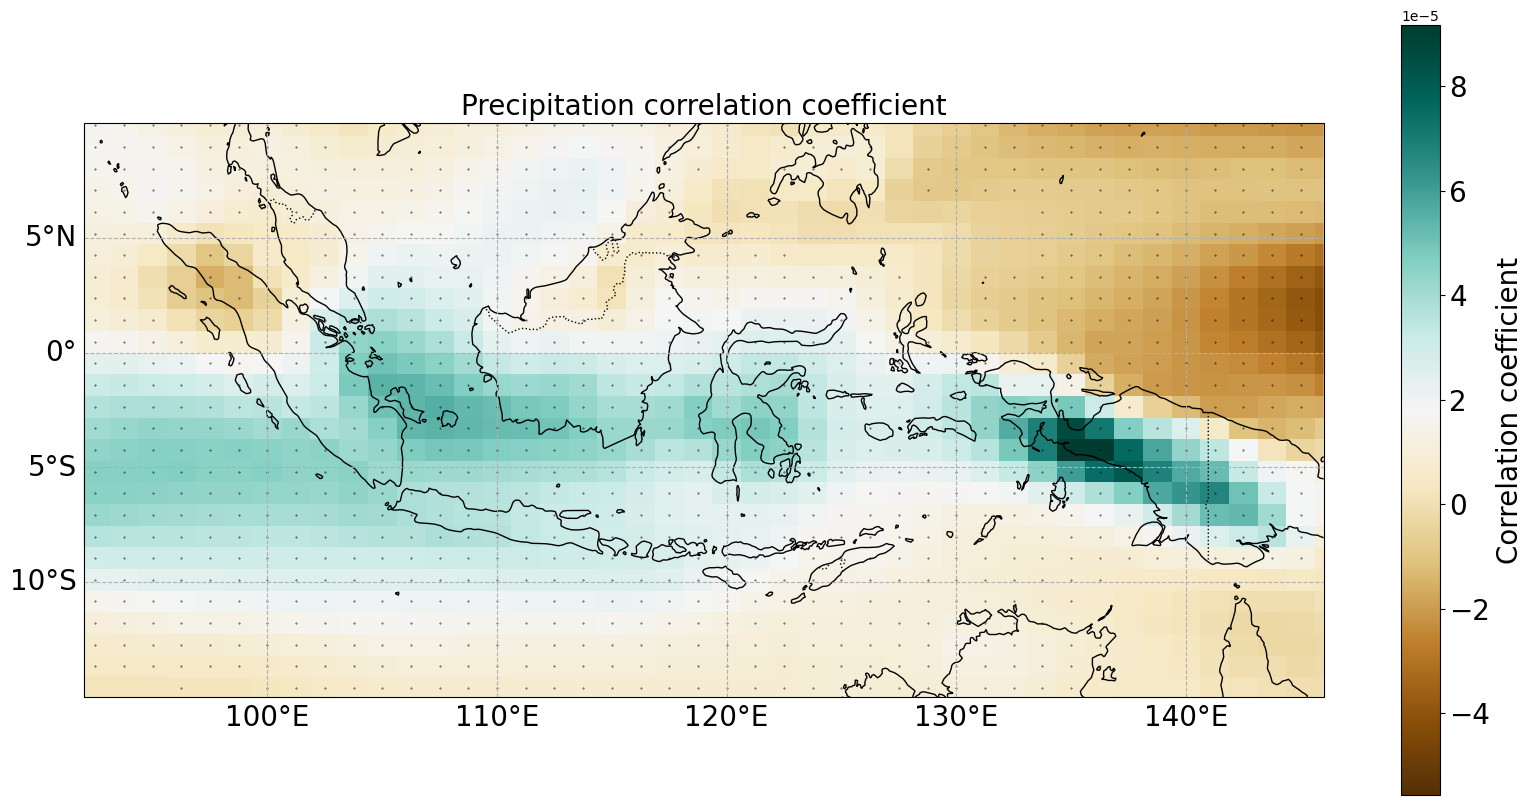

In [25]:
# Plot the results!
map = ccrs.PlateCarree(central_longitude=180)

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot data onto those axes
plot = ax.pcolormesh(this_pr.lon, this_pr.lat, coef_vals.squeeze(), 
                     transform=ccrs.PlateCarree(), cmap="BrBG", shading='auto')# 
# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Correlation coefficient", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.set_extent([92, 146, -15, 10], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Statistical significance for historical vs future precip change regressed on gradient change
latitudes, longitudes = np.where(p_vals.squeeze() < 0.05)
lats = this_pr.coords['lat'][latitudes].values
lons = this_pr.coords['lon'][longitudes].values
ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Precipitation correlation coefficient", fontsize= 20)
plt.show()

In [22]:
coef_vals

<xarray.DataArray (lat: 192, lon: 288)>
array([[ 5.60866703e-08,  5.60861569e-08,  5.60862374e-08, ...,
         5.60921373e-08,  5.60896221e-08,  5.60889343e-08],
       [ 3.95314465e-08,  3.90674807e-08,  3.90972661e-08, ...,
         3.80982694e-08,  3.87981858e-08,  3.95323296e-08],
       [ 1.86597994e-08,  1.89995337e-08,  2.02764300e-08, ...,
         2.13720121e-08,  2.05349981e-08,  1.93454736e-08],
       ...,
       [ 5.65074672e-08,  5.77646660e-08,  5.60994779e-08, ...,
         4.94058087e-08,  5.03319430e-08,  5.32084267e-08],
       [ 1.16472989e-09,  4.52900520e-09,  8.53626327e-09, ...,
        -2.36799221e-09, -1.20318393e-09,  5.72143720e-10],
       [-1.30540164e-07, -1.30482062e-07, -1.30084191e-07, ...,
        -1.30220111e-07, -1.29821766e-07, -1.30167826e-07]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   <U9 'r4i1p1f1'

#### ACCESS-CM2 Model

##### Specify Model

In [23]:
# source_id: which model do you want?
source_id = ["ACCESS-CM2"]

# THIS IS NOT RETURNING ANYTHING

##### Store 'tos'

In [24]:
# Search through catalog, store results for tos
access_res_tos = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, 
                         variable_id='tos', grid_label='gr') # remove gn

# Recreate the data frame
access_tos_df = access_res_tos.df

# Display the data frame
display(access_tos_df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version


##### Store 'pr'

In [ ]:
# Search through catalog, store results for precip
access_res_pr = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, 
                         variable_id='pr')

# Recreate the data frame
access_pr_df = access_res_pr.df

# Display the data frame
display(access_pr_df)

##### Store Results

In [ ]:
# Search through catalog, store results
access_res = catalog.search(activity_id=activity_id, experiment_id=experiment_id,
                         source_id=source_id, table_id=table_id, variable_id=variable_id)

# Create a data frame
access_df = access_res.df

# Look at results
display(access_df)

## Metrics Computation

4. Compute metrics based on extracted data.

Now write additional code to take the set of variables you just extracted, and calculating the
necessary metrics (averages, etc) from them.

## Visualizations

5. Create visualizations of climate change impacts.

Make some plots showing your metrics and how they change as a function of time!

## Conclusions

6. Interpret and contextualize your results.

Finally, wrap it all up with a couple of paragraphs discussing your results and what you think
their implications might be for your region. For instance: what populations or ecosystems
might be impacted? How confident are you that the future changes are different from the
historical climate? Is there anything else you’re excited to talk about?